In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/airline-info/airline-code-dictionary.csv
/kaggle/input/airline-info/dot-code-dictionary.csv
/kaggle/input/flight-data-2022/2022.csv


# Points of Interest:
* **Distribution of flight takeoffs by month.**
* **Top 3 airlines from each origin_city.**
* **Origin_city with the highest takeoffs.**
* **City with the highest number of airports.**
* **Number of Flights per Airline.**
* **Airline with the highest delays.**
* **Origin with the highest delays.**

**Analysis Period: 2022 FY**

In [24]:
FltData = pd.read_csv('/kaggle/input/flight-data-2022/2022.csv')
DotCode = pd.read_csv('/kaggle/input/airline-info/dot-code-dictionary.csv')
AirlineCodeDict = pd.read_csv('/kaggle/input/airline-info/airline-code-dictionary.csv')

In [25]:
FltData.head()

,FL_DATE,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME,...,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,FL_YEAR,FL_MONTH,FL_DAY
0,2022-05-03,OH,20397,5433,DCA,"Washington, DC",ALB,"Albany, NY",1010,1018.0,...,61.0,318.0,NaN,NaN,NaN,NaN,NaN,2022,5,3
1,2022-05-04,OH,20397,5433,DCA,"Washington, DC",ALB,"Albany, NY",1010,1002.0,...,61.0,318.0,NaN,NaN,NaN,NaN,NaN,2022,5,4
2,2022-05-01,OH,20397,5434,CLT,"Charlotte, NC",TLH,"Tallahassee, FL",2046,2039.0,...,57.0,386.0,NaN,NaN,NaN,NaN,NaN,2022,5,1
3,2022-05-02,OH,20397,5434,CLT,"Charlotte, NC",TLH,"Tallahassee, FL",2046,2036.0,...,60.0,386.0,NaN,NaN,NaN,NaN,NaN,2022,5,2
4,2022-05-03,OH,20397,5434,CLT,"Charlotte, NC",TLH,"Tallahassee, FL",2046,2035.0,...,63.0,386.0,NaN,NaN,NaN,NaN,NaN,2022,5,3


In [26]:
DotCode.head()

,Code,Description
0,19031,Mackey International Inc.: MAC
1,19032,Munz Northern Airlines Inc.: XY
2,19033,Cochise Airlines Inc.: COC
3,19034,Golden Gate Airlines Inc.: GSA
4,19035,Aeromech Inc.: RZZ


In [27]:
AirlineCodeDict.head()

,Code,Description
0,02Q,Titan Airways
1,04Q,Tradewind Aviation
2,05Q,"Comlux Aviation, AG"
3,06Q,Master Top Linhas Aereas Ltd.
4,07Q,Flair Airlines Ltd.


**Joining DOT Code & Airline Code with Flight Dataset and Retaining only the required columns.**

In [28]:
FltDataAndDot = pd.merge(FltData, DotCode[['Description']], left_on = 'DOT_CODE', right_on = DotCode['Code']).rename(columns = {'Description': 'DOT_DESC'})
MasterDf = pd.merge(FltDataAndDot, AirlineCodeDict[['Description']], left_on = 'AIRLINE_CODE', right_on = AirlineCodeDict['Code']).rename(columns = {'Description': 'AIRLINE_NAME'})
# Retaining only the required columns
MasterDf = MasterDf[['FL_DATE','AIRLINE_CODE', 'DOT_CODE', 'FL_NUMBER', 'ORIGIN', 'ORIGIN_CITY', 'DEST', 'DEST_CITY', 'CRS_DEP_TIME', 'DEP_TIME', 'DOT_DESC', 'AIRLINE_NAME']]
MasterDf = MasterDf.iloc[:,[0,1,11,2,10,3,4,5,6,7,8,9]]
MasterDf.head()

,FL_DATE,AIRLINE_CODE,AIRLINE_NAME,DOT_CODE,DOT_DESC,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME
0,2022-05-03,OH,PSA Airlines Inc.,20397,PSA Airlines Inc.: OH,5433,DCA,"Washington, DC",ALB,"Albany, NY",1010,1018.0
1,2022-05-04,OH,PSA Airlines Inc.,20397,PSA Airlines Inc.: OH,5433,DCA,"Washington, DC",ALB,"Albany, NY",1010,1002.0
2,2022-05-01,OH,PSA Airlines Inc.,20397,PSA Airlines Inc.: OH,5434,CLT,"Charlotte, NC",TLH,"Tallahassee, FL",2046,2039.0
3,2022-05-02,OH,PSA Airlines Inc.,20397,PSA Airlines Inc.: OH,5434,CLT,"Charlotte, NC",TLH,"Tallahassee, FL",2046,2036.0
4,2022-05-03,OH,PSA Airlines Inc.,20397,PSA Airlines Inc.: OH,5434,CLT,"Charlotte, NC",TLH,"Tallahassee, FL",2046,2035.0


# Distribution of flight takeoffs by month.

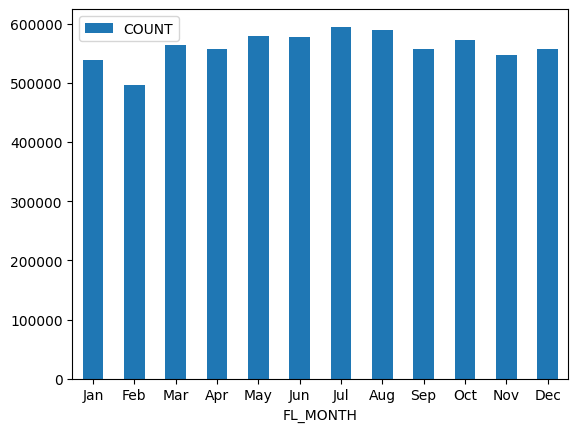

In [29]:
MasterDf['FL_DATE'] = pd.to_datetime(MasterDf.FL_DATE, format='%Y-%m-%d')
DistrByMonth = MasterDf.groupby([MasterDf['FL_DATE'].dt.month]).size().reset_index(name = 'COUNT').rename(columns = {'FL_DATE' : 'FL_MONTH'})
DistrByMonth['FL_MONTH'] = DistrByMonth['FL_MONTH'].replace({1: "Jan", 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'})
ax = DistrByMonth.plot.bar(x='FL_MONTH', y='COUNT', rot=0)

# Top 3 airlines from each origin_city.

In [45]:
TopAirl = MasterDf.groupby(['ORIGIN_CITY', 'AIRLINE_NAME']).size().reset_index(name = 'COUNT')
TopAirl = pd.DataFrame(TopAirl)
# Selecting only the Top 3
TopAirl['RANK'] = TopAirl.groupby('ORIGIN_CITY')['COUNT'].rank(method = 'first', ascending = False)
Top3Airl = TopAirl.loc[TopAirl['RANK']<4].reset_index(drop = True)
Top3Airl[['ORIGIN_CITY', 'AIRLINE_NAME', 'COUNT']].head()

,ORIGIN_CITY,AIRLINE_NAME,COUNT
0,"Aberdeen, SD",SkyWest Airlines Inc.,713
1,"Abilene, TX",Envoy Air,1908
2,"Adak Island, AK",Alaska Airlines Inc.,105
3,"Aguadilla, PR",JetBlue Airways,1077
4,"Aguadilla, PR",Spirit Air Lines,823


# Origin_city with the highest takeoffs.

In [49]:
TkoffCnt = MasterDf.groupby('ORIGIN_CITY').size().reset_index(name = 'TAKEOFF_COUNT').sort_values(by = 'TAKEOFF_COUNT', ascending = False).reset_index(drop = True)
TkoffCnt.head()

,ORIGIN_CITY,TAKEOFF_COUNT
0,"Chicago, IL",337439
1,"Atlanta, GA",317926
2,"New York, NY",305997
3,"Dallas/Fort Worth, TX",276708
4,"Denver, CO",271467


# City with the highest number of airports.

In [70]:
OriginDf = MasterDf[['ORIGIN', 'ORIGIN_CITY']].rename(columns = {'ORIGIN': 'AIRPORT', 'ORIGIN_CITY': 'AIRPORT_CITY'})
DestDf = MasterDf[['DEST', 'DEST_CITY']].rename(columns = {'DEST': 'AIRPORT', 'DEST_CITY': 'AIRPORT_CITY'})
AirportsDf = pd.concat([OriginDf, DestDf], axis =0)
AirportsDf = AirportsDf.drop_duplicates(subset = ['AIRPORT', 'AIRPORT_CITY']).reset_index(drop = True)
AirportsDf = AirportsDf.groupby('AIRPORT_CITY').agg({'AIRPORT': 'count'}).sort_values(by = 'AIRPORT', ascending = False).reset_index().rename(columns = {'AIRPORT': 'AIRPORT_COUNT'})
AirportsDf.head()

,AIRPORT_CITY,AIRPORT_COUNT
0,"Phoenix, AZ",2
1,"Chicago, IL",2
2,"New York, NY",2
3,"Columbus, OH",2
4,"Washington, DC",2


# Number of Flights per Airline.

In [100]:
NumOfFlts = MasterDf.groupby('AIRLINE_NAME').size().reset_index(name = 'COUNT').sort_values(by = 'COUNT', ascending = False).reset_index(drop = True)
NumOfFlts.head()

,AIRLINE_NAME,COUNT
0,Southwest Airlines Co.,1307149
1,Delta Air Lines Inc.,893172
2,American Airlines Inc.,874145
3,SkyWest Airlines Inc.,733576
4,United Air Lines Inc.,626473


# Airline with the highest delays.

In [99]:
# Eliminate cases where CRS Time < Dep Time
OnAndAfterTime = MasterDf.loc[MasterDf['CRS_DEP_TIME'] <= MasterDf['DEP_TIME']]
pd.options.mode.chained_assignment = None
OnAndAfterTime['DELAY_IN_MINS'] = OnAndAfterTime['DEP_TIME'] - OnAndAfterTime['CRS_DEP_TIME']
OnAndAfterTime = OnAndAfterTime.groupby('AIRLINE_NAME').agg({'DELAY_IN_MINS': 'sum'}).sort_values(by = 'DELAY_IN_MINS', ascending = False).reset_index()
OnAndAfterTime['DELAY_IN_HRS'] = (pd.DataFrame(OnAndAfterTime['DELAY_IN_MINS']/60)).round(2)
OnAndAfterTime = OnAndAfterTime[['AIRLINE_NAME', 'DELAY_IN_HRS']]
OnAndAfterTime.head()

,AIRLINE_NAME,DELAY_IN_HRS
0,Southwest Airlines Co.,522780.25
1,American Airlines Inc.,357696.78
2,Delta Air Lines Inc.,266728.18
3,SkyWest Airlines Inc.,237939.30
4,United Air Lines Inc.,231629.83


# Origin with the highest delays.

In [98]:
# Eliminate cases where CRS Time < Dep Time
OnAndAfterTimeAirp = MasterDf.loc[MasterDf['CRS_DEP_TIME'] <= MasterDf['DEP_TIME']]
pd.options.mode.chained_assignment = None
OnAndAfterTimeAirp['DELAY_IN_MINS'] = OnAndAfterTimeAirp['DEP_TIME'] - OnAndAfterTimeAirp['CRS_DEP_TIME']
OnAndAfterTimeAirp = OnAndAfterTimeAirp.groupby('ORIGIN').agg({'DELAY_IN_MINS': 'sum'}).sort_values(by = 'DELAY_IN_MINS', ascending = False).reset_index()
OnAndAfterTimeAirp['DELAY_IN_HRS'] = (pd.DataFrame(OnAndAfterTimeAirp['DELAY_IN_MINS']/60)).round(2)
OnAndAfterTimeAirp = OnAndAfterTimeAirp[['ORIGIN', 'DELAY_IN_HRS']]
OnAndAfterTimeAirp.head()

,ORIGIN,DELAY_IN_HRS
0,DEN,123725.28
1,DFW,110480.50
2,ORD,93780.88
3,ATL,93763.27
4,LAS,75082.93
